# Notebook layout:
This notebook goes over 3 methods to fit a Bayesian model
1. The standard approach where you define all the variables
2. The built in GLM function
3. Using Theano for predicting out of sample

In [1]:
# Import PyMC3
from pymc3 import  *
import pymc3 as pm

# -- Load libraries --
# Data manipulation libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd

# Plotting libaries
import plotnine as pn
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import utils


# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [2]:
# Set random seed
np.random.seed(1)
# Generate some random data
k = 4
n = 100
X = pd.DataFrame([np.random.uniform(-30, 30,100) for _ in range(0,k)]).T
beta  = np.random.uniform(-30, 30, size = 4)

# Setting up linear relationship
mu = np.dot(beta,X.T) 
y = pd.Series(mu + np.random.normal(loc = 0,scale = 50,size = n))
df = pd.concat([pd.Series(np.ones(n)),X], ignore_index = True, axis = 1)
df.columns = ['x0','x1','x2','x3','x4']

# We can also infer new values
# y[90:100] = np.nan


### Model setup
Suppose we have the setup

\begin{align}
Y = X^T\boldsymbol{\beta} +\xi \quad;\quad \boldsymbol{\beta}\sim MVN\left(0,100\cdot I_{2\times 2}\right)\quad;\quad \xi\sim N(0,\sigma^2)\qquad;\quad\sigma^2\sim IG(alpha=0.001,\beta = 0.001)
\end{align}

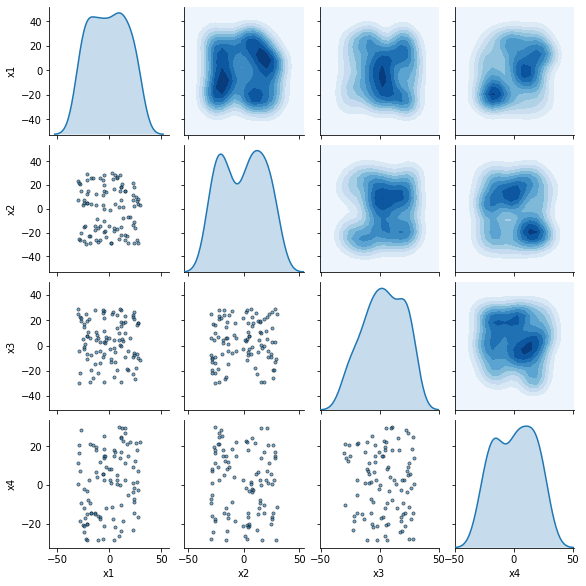

In [3]:
# Create a pairplot to visualize relationship between parameters
g = sns.pairplot(pd.DataFrame(df.iloc[:,1:]),diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 10, 'edgecolor': 'k'},
             size = 2)
g.map_upper(sns.kdeplot, cmap = 'Blues', shade=True, gridsize= 20)

Looks like there are no linear dependencies so we can assume $\boldsymbol{\beta}\sim MVN\left(0,100*\cdot I_{5\times 5}\right)$ is an ok assumption

Below we provide two approaches for the models:
1. We can specify the model directly
2. We can use the builtin GLM function to specify all covariates which is useful when n is large
3. We will define the model using a function and then use the shared variables for future prediction

# The fully specified approach

In [10]:
# For expressiveness we include the full model here
# Instantiate base model
model = Model()
niter = 5000

with model:
    # Define priors
    sigma2 = InverseGamma('sigma2', alpha=1,beta=1/50, testval=1.)
    beta_0 = Normal('beta_0', 0, sigma=100) # note here that the real beta_0 = 0
    beta_1 = Normal('beta_1', 0, sigma=100)
    beta_2 = Normal('beta_2', 0, sigma=100)
    beta_3 = Normal('beta_3', 0, sigma=100)
    beta_4 = Normal('beta_4', 0, sigma=100)

    # Define likelihood
    likelihood = Normal('y', mu = beta_0 * df.x0 + beta_1 * df.x1 + beta_2 * df.x2 + 
                        beta_3 * df.x3 + beta_4 * df.x4, sigma=sigma2, observed=y)

    # Inference!
     # inference
    start = find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = NUTS() # Have a choice of samplers
    trace = sample(niter, step, start, random_seed=123, progressbar=True, cores=2)

# -- Summary stats ---/
summary(trace).round(2)

logp = -578.64, ||grad|| = 6.2472: 100%|██████████| 71/71 [00:00<00:00, 2434.10it/s]    
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_4, beta_3, beta_2, beta_1, beta_0, sigma2]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:23<00:00, 473.43draws/s]
The acceptance probability does not match the target. It is 0.9589778374656386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9537664944567964, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0,-5.50,5.85,-16.40,5.97,0.19,0.14,967.0,860.0,970.0,1058.0,1.0
beta_1,27.49,0.31,26.93,28.09,0.00,0.00,11686.0,11686.0,11661.0,7486.0,1.0
beta_2,18.44,0.29,17.91,18.98,0.00,0.00,12357.0,12357.0,12375.0,7643.0,1.0
beta_3,-27.86,0.33,-28.47,-27.24,0.00,0.00,8956.0,8953.0,8949.0,6895.0,1.0
beta_4,12.55,0.34,11.91,13.18,0.00,0.00,8089.0,8080.0,8108.0,6696.0,1.0
sigma2,54.57,4.02,47.16,62.03,0.05,0.04,5595.0,5358.0,6039.0,5685.0,1.0


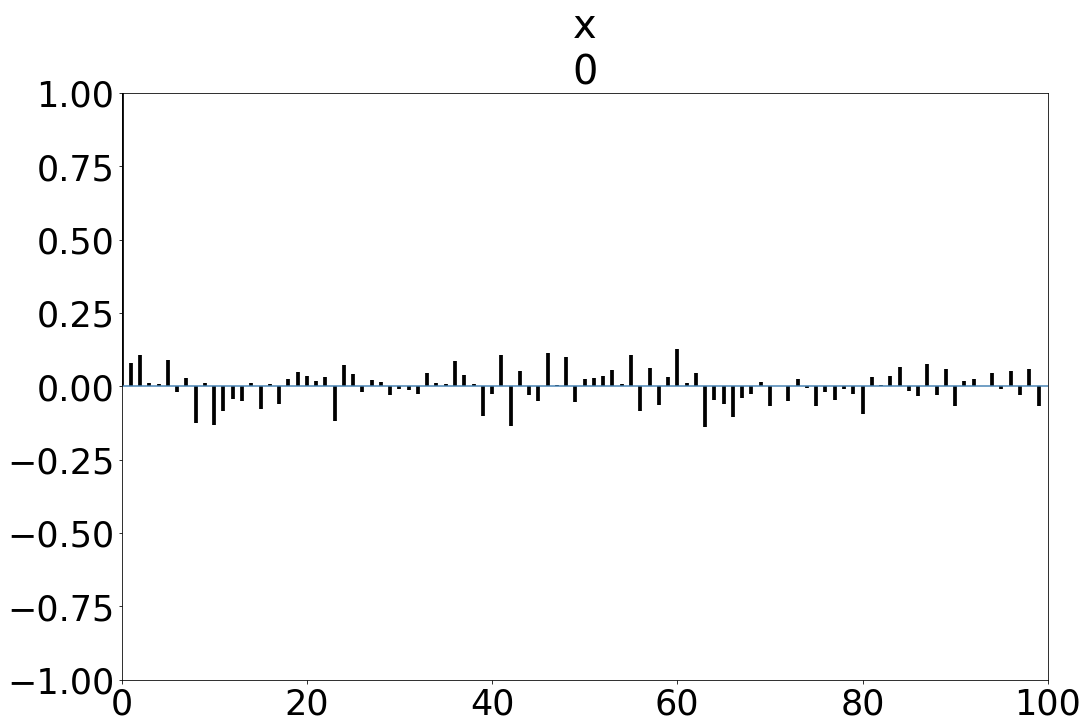

<Figure size 504x504 with 0 Axes>

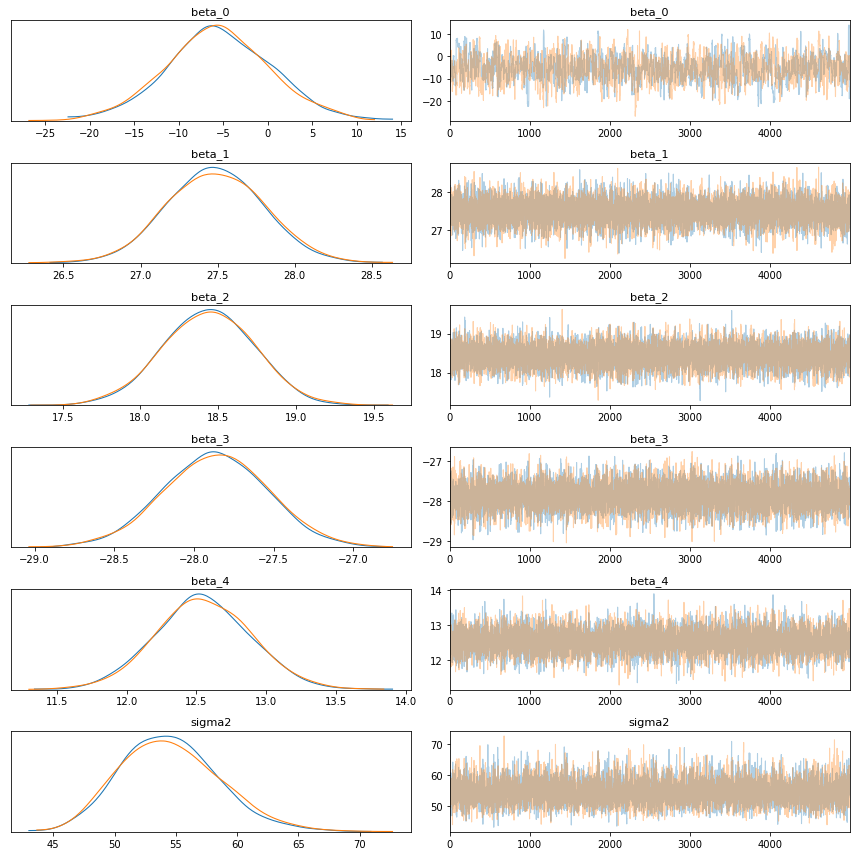

In [11]:
# -- Autocorrelation: Does the sampler mix approriately --
autocorrplot(trace.get_values('beta_0')[::50], figsize=(15,10))
# -- Traceplot: --
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

# Using the GLM function

Note:
- When using GLM the internal mechanics of setting the prior are taken care of for you
- Therefore the result is more a less a black box - however onitce that the results are similar to the model specified with the priors

In [12]:
# Instantiate base model
model_several_covariates = Model()

with model_several_covariates:
    # Note that here we remove "-1" - since the design matrix already includes the intercept
    glm.GLM.from_formula('y ~ x0+x1+x2+x3+x4-1', df)
    start = find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = NUTS() # Have a choice of samplers
    trace = sample(niter, step, start, random_seed=123, progressbar=True, cores=3) 

# -- Summary stats ---/
summary(trace).round(2)

logp = -584.19, ||grad|| = 5.2854e-05: 100%|██████████| 72/72 [00:00<00:00, 2723.25it/s]  
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x4, x3, x2, x1, x0]
Sampling 3 chains, 0 divergences: 100%|██████████| 16500/16500 [00:30<00:00, 535.60draws/s]
The acceptance probability does not match the target. It is 0.9587980823808148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9522953454294607, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.988953015348431, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0,-5.21,5.71,-16.17,5.38,0.15,0.11,1446.0,1446.0,1451.0,1654.0,1.0
x1,27.48,0.32,26.86,28.07,0.00,0.00,12984.0,12984.0,13008.0,9350.0,1.0
x2,18.44,0.29,17.88,18.98,0.00,0.00,15292.0,15292.0,15281.0,10025.0,1.0
x3,-27.86,0.33,-28.50,-27.25,0.00,0.00,11750.0,11736.0,11760.0,9176.0,1.0
x4,12.55,0.33,11.94,13.18,0.00,0.00,9863.0,9859.0,9862.0,8697.0,1.0
sd,54.57,3.96,47.43,62.04,0.04,0.03,10559.0,10285.0,10935.0,8192.0,1.0


For the model 
- Note here that there is some autocorrelation for $\beta_0$
- We can thin the samples by taking every 20th sample generated

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146212e48>]],
      dtype=object)

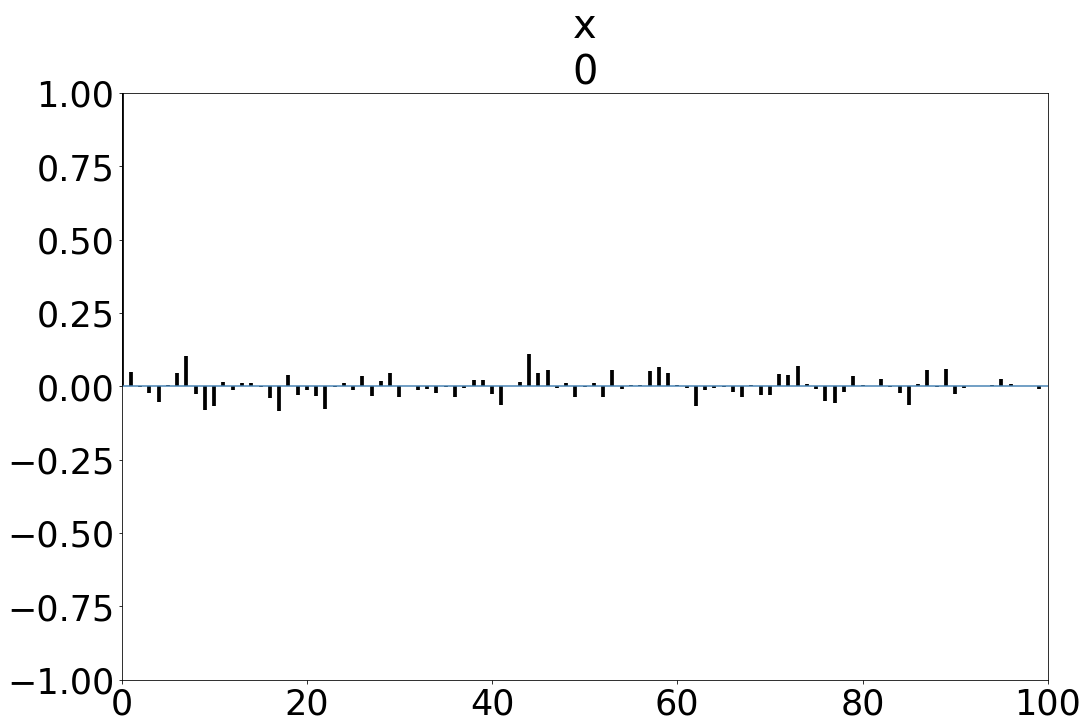

In [13]:
# -- Autocorrelation: Does the sampler mix approriately --
autocorrplot(trace.get_values('x0')[::20], figsize=(15,10))

<Figure size 504x504 with 0 Axes>

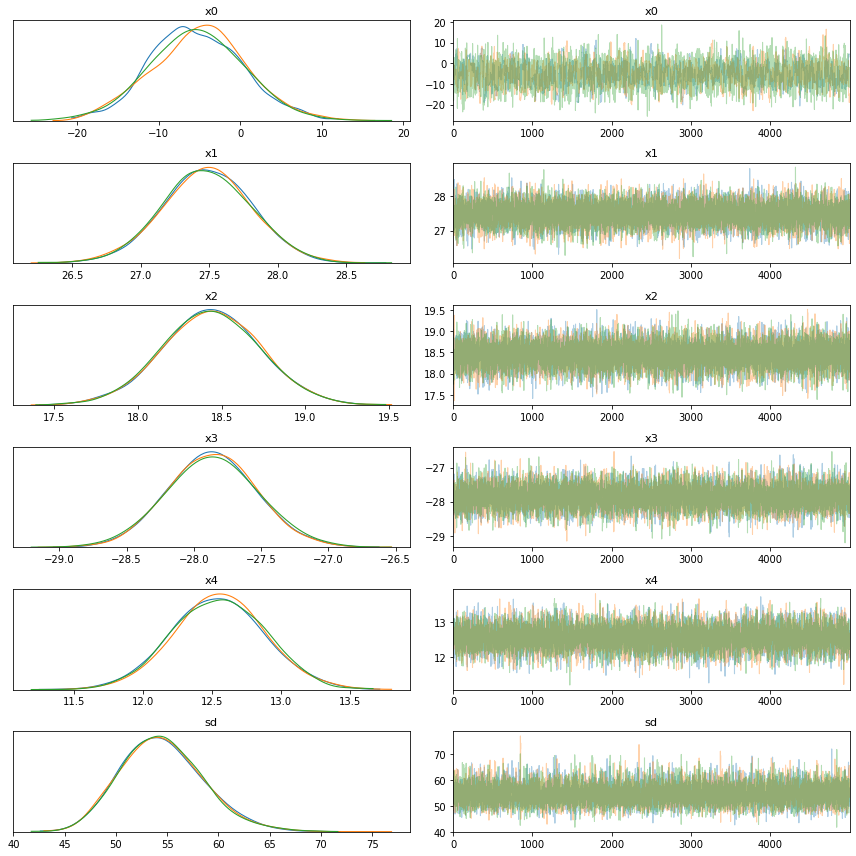

In [14]:
# -- Traceplot: --
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

# Predicting future values using theano

### Out of sample predictions (we'll need this later)
- Here we instantiate theano 
- We then tell pymc3 that we will be predicting variables and that it needs to share the model with the out of sample values

In [15]:
# Turn predictor into a shared var so that we can change it later
shared_x0 = shared(df.x0.values)
shared_x1 = shared(df.x1.values)
shared_x2 = shared(df.x2.values)
shared_x3 = shared(df.x3.values)
shared_x4 = shared(df.x4.values)
shared_xs = [shared_x0,shared_x1,shared_x2,shared_x3,shared_x4]
target_shared_y = shared(y.values)

In [16]:
niter = 3000
# Building a model factory
def model_factory(shared_values, y):
    with Model() as model_out:
        # Define priors
        sigma2 = InverseGamma('sigma2', alpha=1,beta=1/50, testval=1.)
        beta_0 = Normal('beta_0', 0, sigma=100) # note here that the real beta_0 = 0
        beta_1 = Normal('beta_1', 0, sigma=100)
        beta_2 = Normal('beta_2', 0, sigma=100)
        beta_3 = Normal('beta_3', 0, sigma=100)
        beta_4 = Normal('beta_4', 0, sigma=100)

        # Define likelihood
        likelihood = Normal('y', mu = beta_0 * shared_values[0] +
                            beta_1 * shared_values[1] + 
                            beta_2 * shared_values[2] + 
                            beta_3 * shared_values[3] + 
                            beta_4 * shared_values[4], 
                            sigma=sigma2, observed=y)
 
    return model_out
 
## Running model now
with model_factory(shared_xs, target_shared_y) as model:
    # Inference!
    start = find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = NUTS() # Have a choice of samplers
    trace = sample(niter, 
                   step,
                   start,
                   random_seed=123, 
                   progressbar=True, 
                   cores=3)



logp = -578.64, ||grad|| = 6.2472: 100%|██████████| 71/71 [00:00<00:00, 2658.79it/s]    
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_4, beta_3, beta_2, beta_1, beta_0, sigma2]
Sampling 3 chains, 0 divergences: 100%|██████████| 10500/10500 [00:19<00:00, 528.04draws/s]
The acceptance probability does not match the target. It is 0.9585211984229475, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9531089796358954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9541892314984025, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


<Figure size 504x504 with 0 Axes>

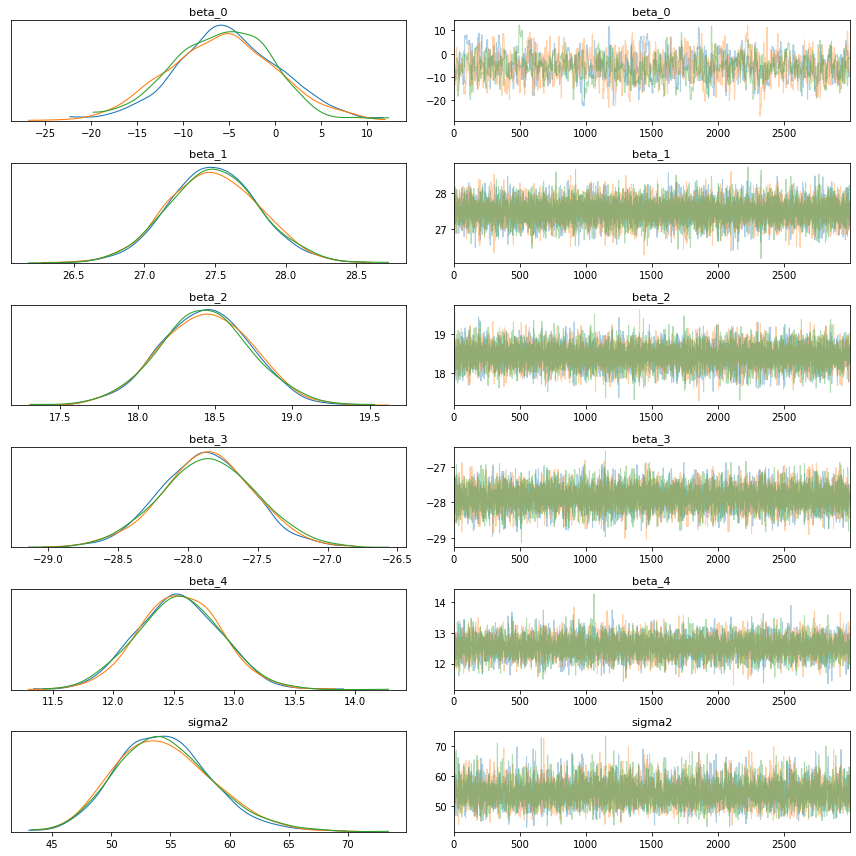

In [17]:
# -- Traceplot: --
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

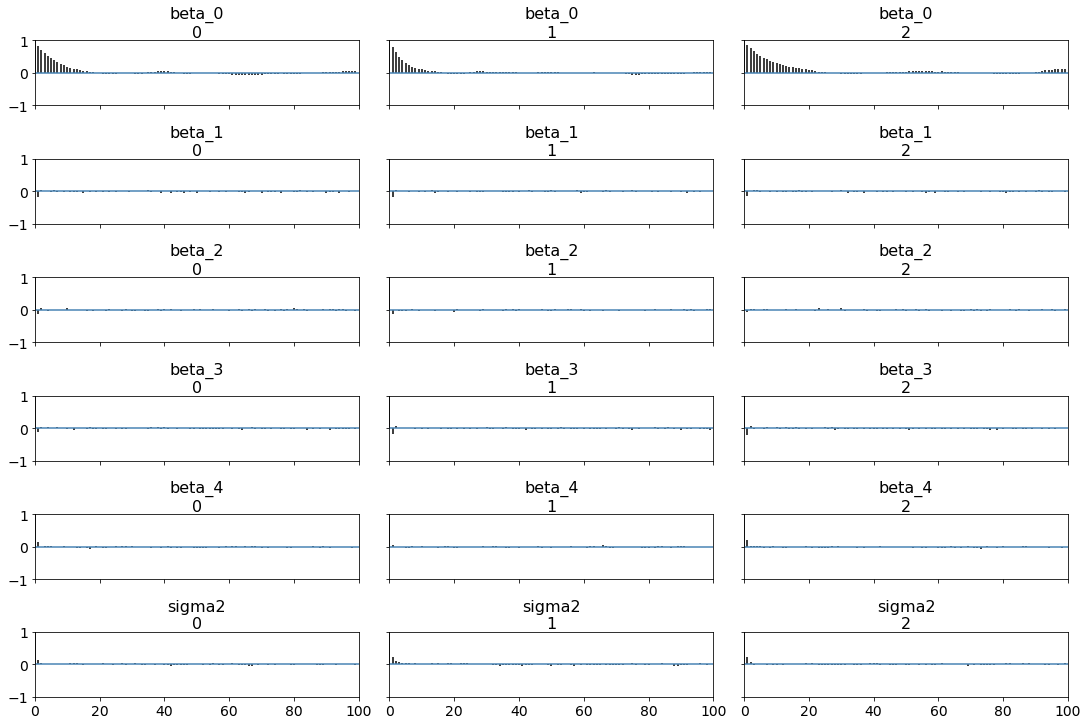

In [18]:
# -- Autocorrelation: Does the sampler mix approriately --
a = autocorrplot(trace, figsize=(15,10))

### Out of sample prediction
- Now using our shared variable we can go ahead and predict on new values

In [21]:
# How many new observations?
n_oos = 2

# Setup out of sample random values
X_oos = np.matrix([np.random.uniform(-30, 30,k) for _ in range(0,n_oos)])
df_oos = np.append(np.ones([n_oos,1]), X_oos,1) # appending our 1s values for our intercept y

# Updating the shared values with our new values
shared_x0.set_value(np.array(df_oos[:,0]).flatten())
shared_x1.set_value(np.array(df_oos[:,1]).flatten())
shared_x2.set_value(np.array(df_oos[:,2]).flatten())
shared_x3.set_value(np.array(df_oos[:,3]).flatten())
shared_x4.set_value(np.array(df_oos[:,4]).flatten())

simulated_samples = 60
with model:
    post_pred = pm.sample_ppc(trace, samples=simulated_samples)

Y_posterior_predictive = pd.DataFrame(post_pred['y'])
Y_posterior_predictive.columns = ['Posterior_predictive_Y_new_obs_1','Posterior_predictive_Y_new_obs_2']
Y_posterior_predictive.head()

100%|██████████| 60/60 [00:00<00:00, 75.49it/s]


In [22]:
# Quick check to make sure that our data was updated the output should be n_oos x 60
print('The output should be {a} = {b}'.format(a=(simulated_samples,n_oos), b= post_pred['y'].shape))

The output should be (60, 2) = (60, 2)


In [23]:
Y_posterior_predictive = pd.DataFrame(post_pred['y'])
Y_posterior_predictive.columns = ['Posterior_predictive_Y_new_obs_1','Posterior_predictive_Y_new_obs_2']
Y_posterior_predictive.head()

,Posterior_predictive_Y_new_obs_1,Posterior_predictive_Y_new_obs_2
0,-7.689260,120.484641
1,18.249688,48.640356
2,111.565898,195.792243
3,76.770485,264.303275
4,70.301969,58.882163


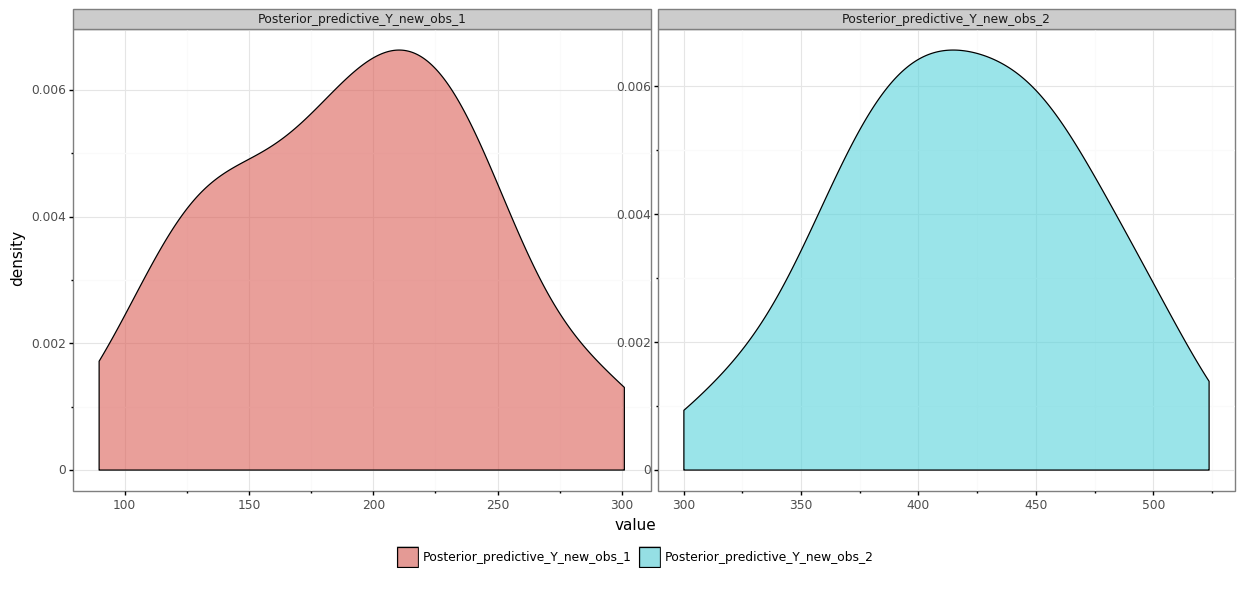

<ggplot: (331771547)>

In [177]:
# -- Plotting distributions for posterior predictive ---
Y_posterior_predictive = Y_posterior_predictive.unstack().reset_index()
Y_posterior_predictive.columns = ['new_sample','i','value']

# Plot options
pn.options.figure_size = (15,6)
pn.options.dpi = 100

### Trace plot
ggplot(aes(x = 'value',fill = 'factor(new_sample)'),data = Y_posterior_predictive)\
+ geom_density(alpha = 0.6,size = 0.5)\
+ theme_bw()\
+ facet_wrap(['new_sample'], scales='free')\
+ theme(legend_position=(.5, .0), 
        legend_direction='horizontal', 
        legend_title=element_blank())